# Import Public Transport Network for GTFS file

In [40]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel
from quetzal.io.gtfs_reader import importer

import geopandas as gpd
from shapely import geometry

if manual:
    %matplotlib inline
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

import os 
input_folder = os.path.join(argv['training_folder'], 'inputs/')

# Read GTFS feed

In [41]:
full_feed = importer.GtfsImporter(path = input_folder + r'/IDFM_gtfs.zip', dist_units='m') 
# downloaded from https://data.iledefrance-mobilites.fr/explore/dataset/offre-horaires-tc-gtfs-idf/table/

## Restrict Feed

In [42]:
# To date
feed_r = full_feed.restrict(
    dates=['20200204'] # the dates must be within the feed start and end dates
)

In [43]:
# To AM period
time_range = ['07:00:00', '10:00:00'] #on peut limiter à la période de pointe
feed_t = feed_r.restrict(time_range=time_range)

In [44]:
# To zones polygon
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

zones = gpd.read_file(input_folder + 'zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

# Convert Feed to frequency based links and nodes

In [45]:
# Detect trip parterns
feed = feed_s.copy()
feed.group_services()
feed.build_stop_clusters(distance_threshold=300)
feed.build_patterns(on='cluster_id')

In [46]:
# Convert feed to frequencies
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|██████████| 423/423 [00:05<00:00, 79.87it/s] 


In [47]:
# Create links and node tables
feed_frequencies.build_links_and_nodes(use_utm=False)
feed_frequencies.links.head(1)

index                 a              trip_id  link_sequence  \
0      9  StopPoint:14:411  098098001:DIRECT1_0              1   

   departure_time  pickup_type                   b  arrival_time  \
0         26340.0            0  StopPoint:14:14977       27600.0   

   drop_off_type    time  ...  shape_id agency_id route_short_name  \
0              0  1260.0  ...      None       896         DIRECT 1   

   route_long_name route_desc route_type  route_url route_color  \
0  LE BUS DIRECT 1        NaN          3        NaN      B20066   

   route_text_color                                         geometry  
0            ffffff  LINESTRING (2.32056 48.83935, 2.28638 48.86276)  

[1 rows x 31 columns]

In [48]:
feed_frequencies.nodes.head(1)

stop_id      stop_name stop_desc zone_id stop_url  \
315  StopArea:8738102  PORTE MAILLOT       NaN     NaN      NaN   

     location_type parent_station  wheelchair_boarding  cluster_id  \
315              1            NaN                  NaN         187   

                     geometry  
315  POINT (2.28258 48.87811)

In [49]:
# renaming route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

mapping = {'tram':3.0, 'subway':3.0, 'rail':5.0, 'bus':1.5, 'funicular':3.0}
feed_frequencies.links['route_width'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

# Export 

In [50]:
link_col = ['index', 'a', 'trip_id', 'link_sequence', 'pickup_type', 'b', 'drop_off_type', 'time', 'headway',
    'route_id', 'trip_headsign', 'direction_id', 'agency_id', 'route_type', 'route_short_name', 'route_color', 'geometry', 'route_width']
node_col = ['stop_id', 'stop_name', 'geometry']

In [51]:
sm = stepmodel.StepModel(epsg = 4326, coordinates_unit = 'degree')
sm.links = feed_frequencies.links[link_col].copy()

sm.nodes = feed_frequencies.nodes[node_col].copy()
sm.nodes.index = sm.nodes["stop_id"]

sm.to_json(os.path.join(input_folder, 'gtfs'), only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|██████████| 8/8 [00:00<00:00, 14.57it/s]


Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████| 8/8 [00:00<00:00, 46.75it/s]


KeyError: 'zones'

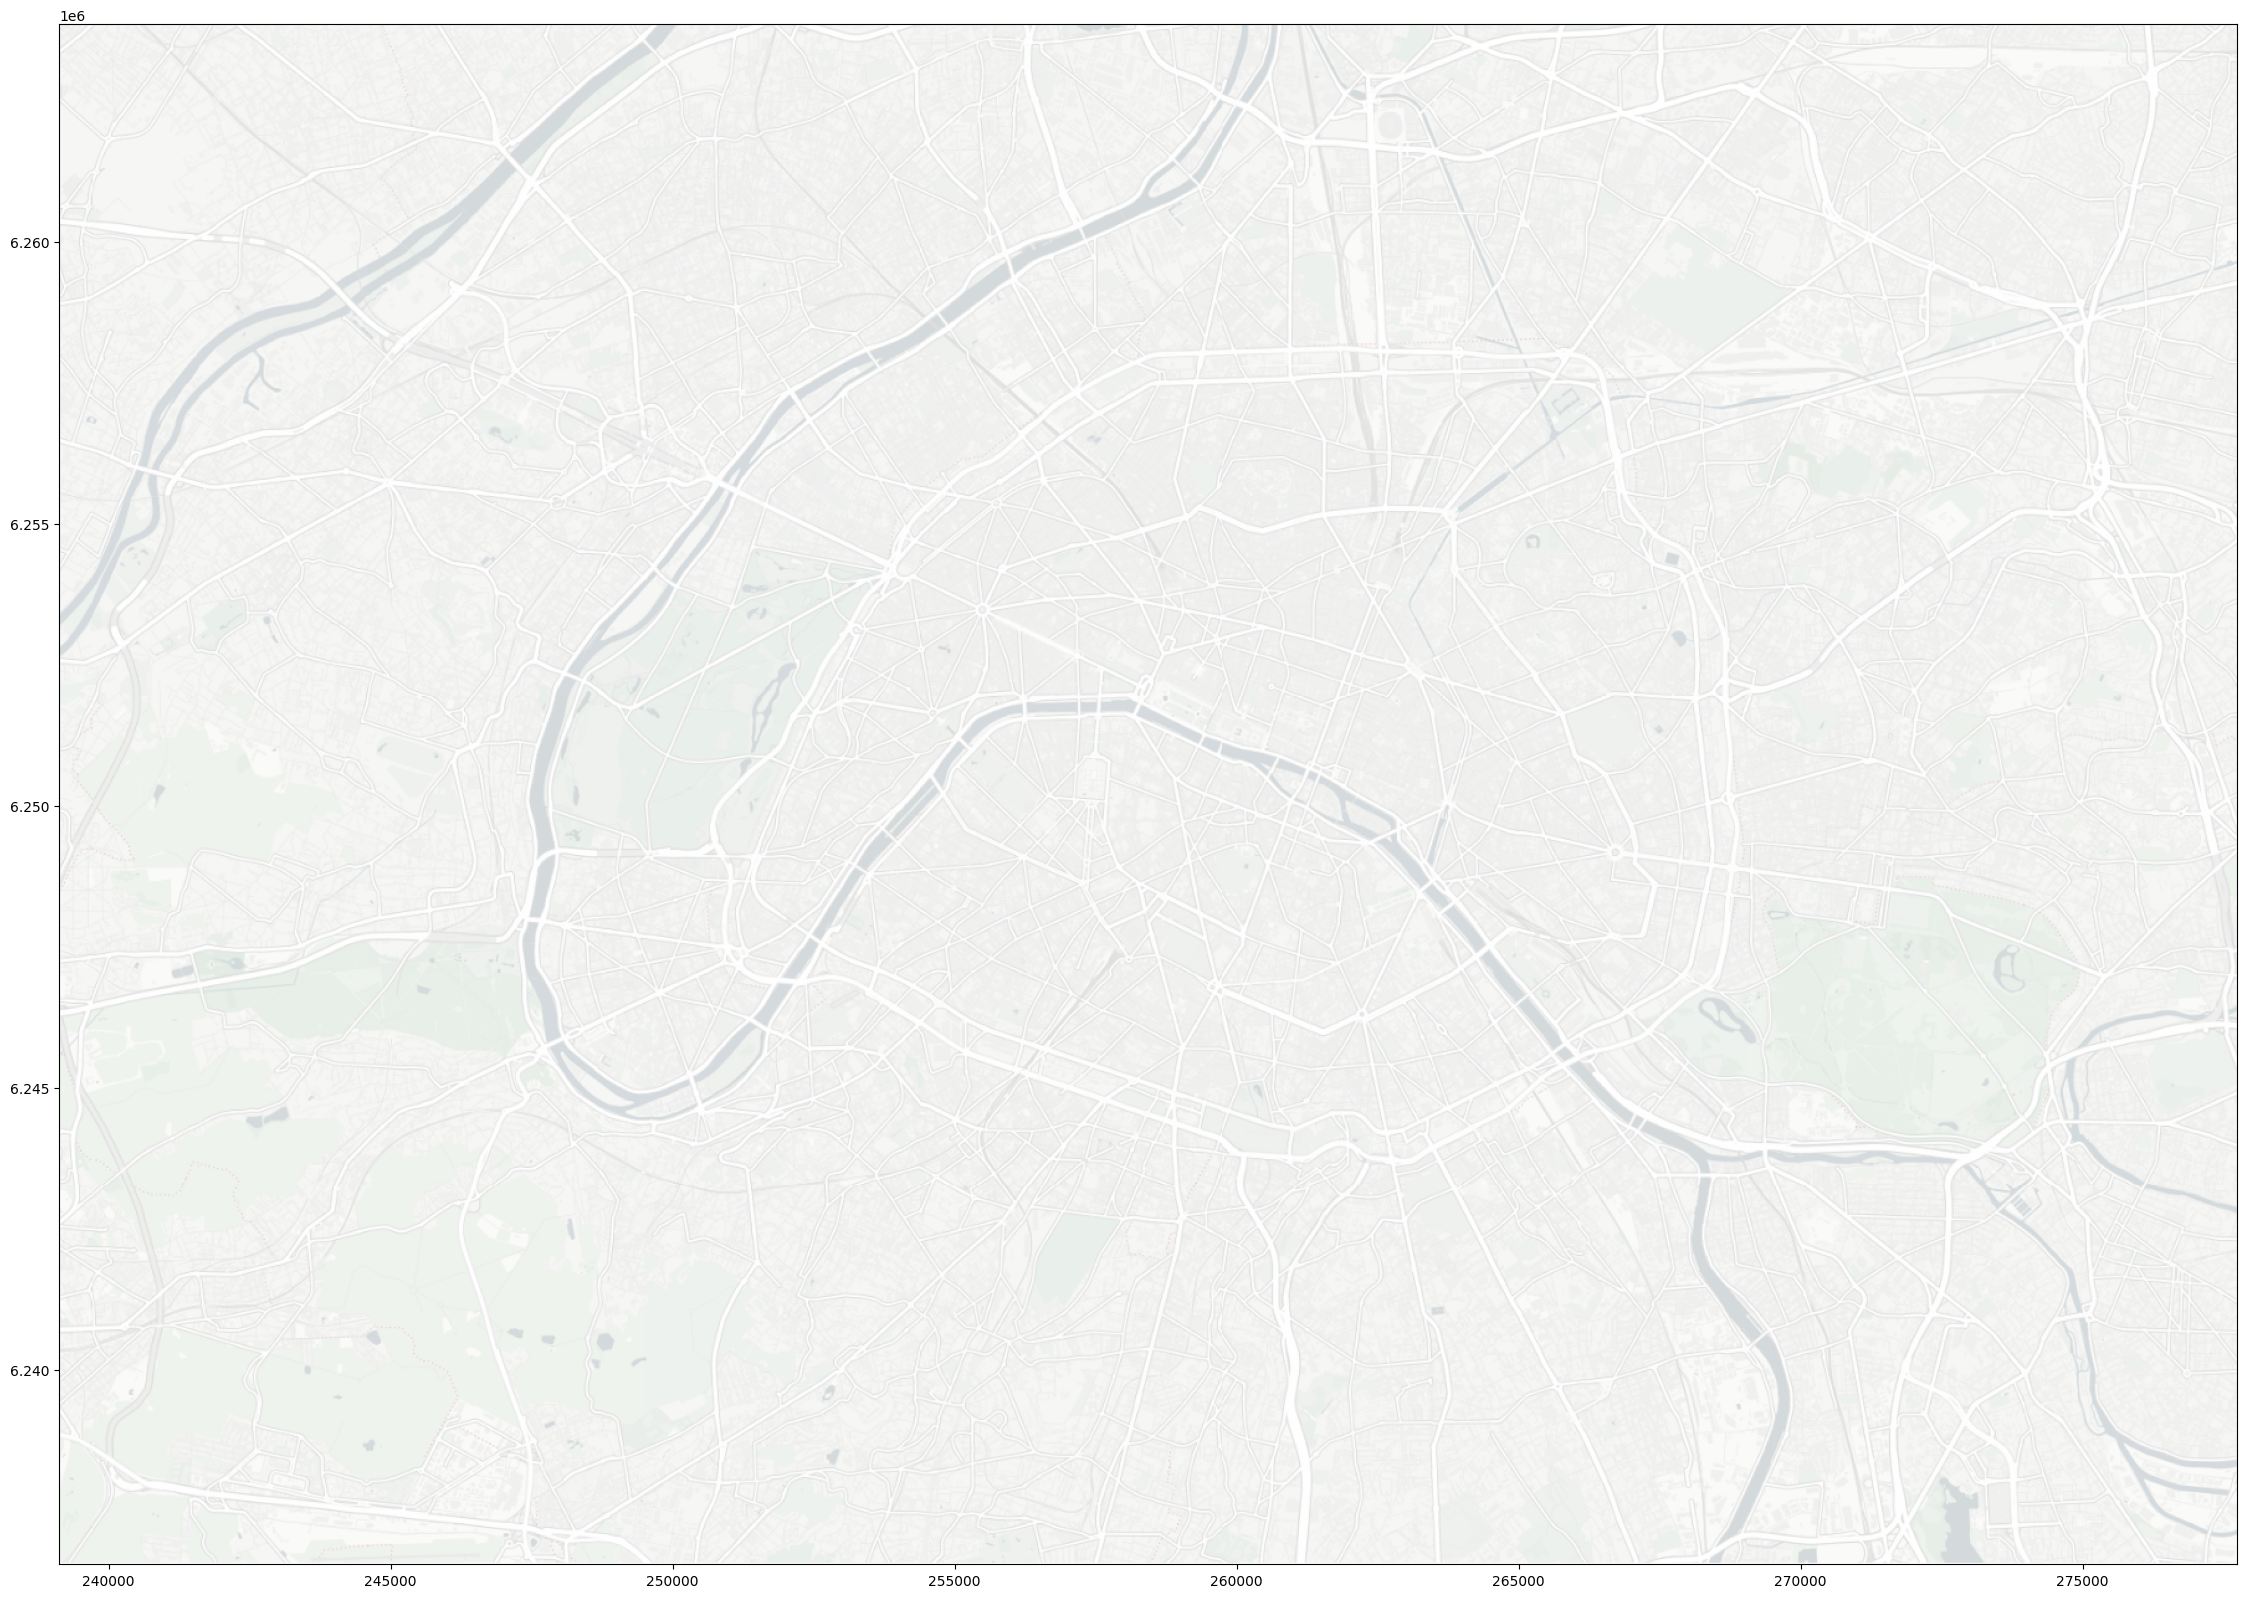

In [52]:
if manual:
    sm_3587 = sm.change_epsg(epsg=3857, coordinates_unit='meter')
    import rasterio
    raster_paris = rasterio.open(input_folder+'/basemap/base.tif')
    fig, ax = plt.subplots(figsize=[40, 20])
    rasterio.plot.show(raster_paris, adjust=None,ax=ax,
                   cmap='gray')
    ax = sm_3587.plot('zones',alpha=0.1, color='blue',ax=ax)
    ax = sm_3587.plot('links',linewidth=0.5, color='green',ax=ax)
    plot= sm_3587.plot('nodes',markersize=0.7, color='red', ax=ax)